# Explanation 

This notebook is going to include all the models which are build using Neurol Networks approach. 
I specified some bunch of models that I am going to deploy. 

- to do: Models will be stayed here ! Dont forget !  

# Get the Data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 

data = pd.read_csv("/content/drive/MyDrive/datasets/deep_data_merged_all_class.csv")
data.head()

,Unnamed: 0,text,target
0,0,We know that effectively exercising your legs ...,0
1,1,Stressed out? 😩\r\nTired? 😴\r\nWorn down? 😰\r\...,0
2,2,Time to get rockin' and *foam* rollin' ! Last ...,0
3,3,"@that_zach_berg Hi Zach, can you please DM us?...",0
4,4,"@iam_rahulsingh @vikasjain1977 Hi, thank you f...",0


In [3]:
train_df_shuffled = data.sample(frac=1, random_state=42) 
train_df_shuffled.head() 

,Unnamed: 0,text,target
644,644,"@chriskrieger91 Hi, thanks for reaching out! W...",0
23615,4272,New episode of the @JalenRose: Renaissance Man...,5
17142,2680,Gordon Ramsay Hell’s Kitchen will open in Chic...,4
9962,468,"N95s, which seal tighter to the face, offer be...",2
19789,446,From exorcisms to weddings — the #Grammys have...,5


##### Balanced Dataset 

In [4]:
train_df_shuffled.target.value_counts()

3    4976
2    4968
5    4954
4    4881
1    4829
0    4665
Name: target, dtype: int64

In [5]:
import random 
random_index = random.randint(0, len(data) - 5) 

for  _, text, target in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 4 (real disaster)
Text:
RT @TheBest_Eighty8: @RobertIrvine Hawaii, Tropic  Lightning  land

---

Target: 3 (real disaster)
Text:
Teenage Engineering’s tiny, orange, bendable PC case is back on sale https://t.co/q9kHEl3inE https://t.co/UrDB1mnTaB

---

Target: 2 (real disaster)
Text:
RT @FoxNews: Fox News Decision Desk can project that independent Vermont Senator @BernieSanders will easily win a third term by defeating R…

---

Target: 4 (real disaster)
Text:
“Nutrition clubs” are popping up across the country as technicolor tea shops, and almost every single one of them is affiliated with the same multi-level-marketing company https://t.co/DCjJ76iFeH

---

Target: 1 (real disaster)
Text:
RT @si_mlb: What do you think about the Nationals City Connect uniforms? 👀

(via @Nationals)
https://t.co/s7JastVU89

---



# Split data into training and validation sets

In [6]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2,
                                                                            random_state=42) 


In [7]:
train_labels

array([3, 2, 1, ..., 0, 3, 3])

In [8]:
import pandas as pd 

train_labels_dummy = pd.get_dummies(train_labels).astype('float32').values 
val_labels_dummy = pd.get_dummies(val_labels).astype('float32').values 

# Converting text into numbers

## Text vectorization (tokenization)


In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True)

In [10]:
# tweet başına kelime sayısı 
round( 
    sum(
        [len(i.split()) for i in train_sentences]
    ) / len(train_sentences)
) 

18

In [11]:
max_vocab_length = 10000 
max_length = 18 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    output_sequence_length=max_length)

In [12]:
text_vectorizer.adapt(train_sentences)

In [13]:
sample_sentence = "There is a flood in my suburb!" 
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 18), dtype=int64, numpy=
array([[109,   9,   5,   1,   6,  81,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]])>

## Embedding Layer  

In [14]:
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128,
                             input_length=max_length,
                             name="embedding_1") 

embedding

In [15]:
embedding(text_vectorizer(train_sentences[0]))

<tf.Tensor: shape=(18, 128), dtype=float32, numpy=
array([[ 0.00489832,  0.03359935, -0.03693479, ...,  0.0462946 ,
        -0.01629032,  0.02559719],
       [ 0.00489832,  0.03359935, -0.03693479, ...,  0.0462946 ,
        -0.01629032,  0.02559719],
       [-0.03639229,  0.04452708,  0.00293303, ...,  0.01932986,
        -0.00161259, -0.0071046 ],
       ...,
       [-0.03928795, -0.03663001, -0.04555485, ..., -0.019331  ,
        -0.04723166, -0.01723748],
       [-0.03928795, -0.03663001, -0.04555485, ..., -0.019331  ,
        -0.04723166, -0.01723748],
       [-0.03928795, -0.03663001, -0.04555485, ..., -0.019331  ,
        -0.04723166, -0.01723748]], dtype=float32)>

In [16]:
initial_embedding_weigths = embedding.get_weights() 

In [17]:
# embedding.set_weights(initial_embedding_weigths)

In [18]:
train_sentences.shape,train_labels.shape

((23418,), (23418,))

## Build Models 
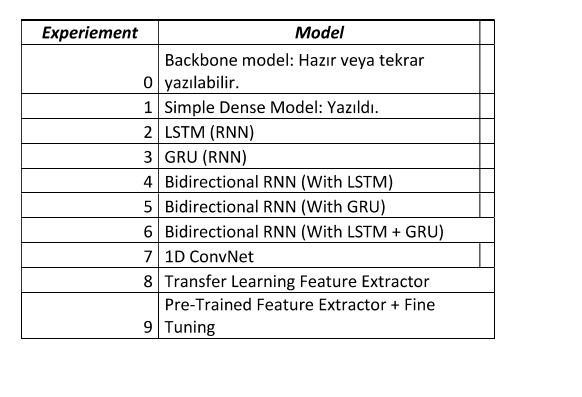

### Model 0: Baseline (Naive Bayes) 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf 
    ("clf", MultinomialNB()) # model the text 
])

model_0.fit(train_sentences, train_labels) 

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 88.37%


In [21]:
from sklearn.metrics import accuracy_score
results = dict() 
results["model_0"] = {
    "validation": model_0.score(val_sentences, val_labels), 
    "training": model_0.score(train_sentences, train_labels)
}

results

{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035}}

### Model 1: A simple dense model


In [22]:
import numpy as np 

inputs = layers.Input(shape=(1,), dtype="string") # inputs 
x = text_vectorizer(inputs) 
x = embedding(x) # create an embedding of the numerized numbers 
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [23]:
model_1.summary() 


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 18, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1,280,774
Trainable params: 1,280,774
Non-tra

In [24]:
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"]) 

In [25]:
batch_size = train_sentences.shape[0] / 732
batch_size

31.991803278688526

In [26]:
model_1_history = model_1.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5)

Epoch 1/5
732/732 [==============================] - 6s 5ms/step - loss: 1.0972 - accuracy: 0.7210 - val_loss: 0.5782 - val_accuracy: 0.8444
Epoch 2/5
732/732 [==============================] - 4s 5ms/step - loss: 0.3978 - accuracy: 0.8917 - val_loss: 0.3897 - val_accuracy: 0.8827
Epoch 3/5
732/732 [==============================] - 4s 5ms/step - loss: 0.2468 - accuracy: 0.9301 - val_loss: 0.3388 - val_accuracy: 0.8909
Epoch 4/5
732/732 [==============================] - 3s 5ms/step - loss: 0.1739 - accuracy: 0.9517 - val_loss: 0.3170 - val_accuracy: 0.8951
Epoch 5/5
732/732 [==============================] - 3s 5ms/step - loss: 0.1288 - accuracy: 0.9642 - val_loss: 0.3155 - val_accuracy: 0.8967


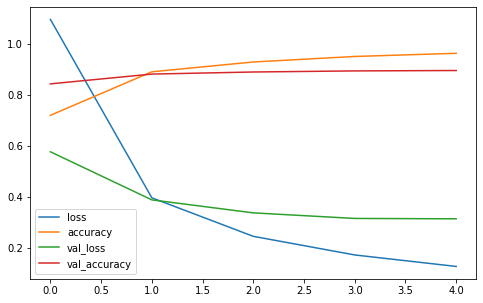

In [27]:
import matplotlib.pyplot as plt 

pd.DataFrame(model_1_history.history).plot(figsize=(8, 5))
plt.show()

In [28]:
results["model_1"] = {
    "validation": model_1.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_1.evaluate(train_sentences, train_labels_dummy)[1]
}

732/732 [==============================] - 2s 3ms/step - loss: 0.0955 - accuracy: 0.9776


In [29]:
results

{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458}}

### Model 2: LSTM 

In [30]:
embedding.set_weights(initial_embedding_weigths)

In [31]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, activation="tanh")(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

In [32]:
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 
model_2_history = model_2.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5)

Epoch 1/5
732/732 [==============================] - 11s 9ms/step - loss: 0.7320 - accuracy: 0.7346 - val_loss: 0.4210 - val_accuracy: 0.8659
Epoch 2/5
732/732 [==============================] - 5s 7ms/step - loss: 0.2537 - accuracy: 0.9202 - val_loss: 0.3753 - val_accuracy: 0.8784
Epoch 3/5
732/732 [==============================] - 5s 7ms/step - loss: 0.1500 - accuracy: 0.9540 - val_loss: 0.4312 - val_accuracy: 0.8705
Epoch 4/5
732/732 [==============================] - 5s 7ms/step - loss: 0.1069 - accuracy: 0.9671 - val_loss: 0.4221 - val_accuracy: 0.8770
Epoch 5/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0716 - accuracy: 0.9777 - val_loss: 0.4666 - val_accuracy: 0.8751


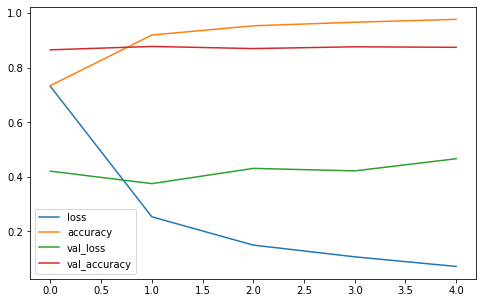

In [33]:
pd.DataFrame(model_2_history.history).plot(figsize=(8, 5))
plt.show()

- Over-fitting problem over here. 

In [34]:
results["model_2"] = {
    "validation": model_2.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_2.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 3s 4ms/step - loss: 0.0492 - accuracy: 0.9859


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543}}

### Model 3: GRU 

In [35]:
embedding.set_weights(initial_embedding_weigths)

In [36]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

In [37]:
model_3.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 
model_3_history = model_2.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5)

Epoch 1/5
732/732 [==============================] - 5s 7ms/step - loss: 0.4699 - accuracy: 0.8386 - val_loss: 0.3571 - val_accuracy: 0.8803
Epoch 2/5
732/732 [==============================] - 5s 7ms/step - loss: 0.1598 - accuracy: 0.9459 - val_loss: 0.3696 - val_accuracy: 0.8852
Epoch 3/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0902 - accuracy: 0.9703 - val_loss: 0.4576 - val_accuracy: 0.8787
Epoch 4/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0674 - accuracy: 0.9777 - val_loss: 0.5049 - val_accuracy: 0.8740
Epoch 5/5
732/732 [==============================] - 5s 7ms/step - loss: 0.0513 - accuracy: 0.9817 - val_loss: 0.5242 - val_accuracy: 0.8709


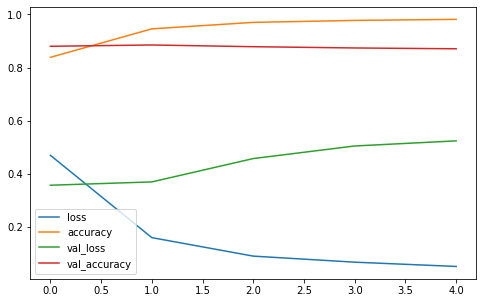

In [38]:
pd.DataFrame(model_3_history.history).plot(figsize=(8, 5))
plt.show()

In [39]:
results["model_3"] = {
    "validation": model_3.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_3.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 3s 4ms/step - loss: 1.7960 - accuracy: 0.1965


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543},
 'model_3': {'validation': 0.189239963889122, 'training': 0.19647279381752014}}

### Model 4: Bidirectional RNN 

In [40]:
embedding.set_weights(initial_embedding_weigths)

In [41]:
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.Bidirectional(layers.LSTM(64))(x) 
outputs = layers.Dense(len(np.unique(train_labels)), activation="sigmoid")(x) 

model_4 = tf.keras.Model(
    inputs, 
    outputs, 
    name="model_4_bidirectional"
)

In [42]:
model_4.summary() 

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 18, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,379,590
Trainable params: 1,3

In [43]:
model_4.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["accuracy"] 
)

history_model_4 = model_4.fit(train_sentences,
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=5) 

Epoch 1/5
732/732 [==============================] - 11s 11ms/step - loss: 0.6436 - accuracy: 0.7725 - val_loss: 0.3728 - val_accuracy: 0.8733
Epoch 2/5
732/732 [==============================] - 7s 9ms/step - loss: 0.2092 - accuracy: 0.9319 - val_loss: 0.3652 - val_accuracy: 0.8775
Epoch 3/5
732/732 [==============================] - 7s 9ms/step - loss: 0.1158 - accuracy: 0.9613 - val_loss: 0.4094 - val_accuracy: 0.8803
Epoch 4/5
732/732 [==============================] - 7s 10ms/step - loss: 0.0783 - accuracy: 0.9747 - val_loss: 0.4781 - val_accuracy: 0.8714
Epoch 5/5
732/732 [==============================] - 7s 9ms/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 0.4836 - val_accuracy: 0.8786


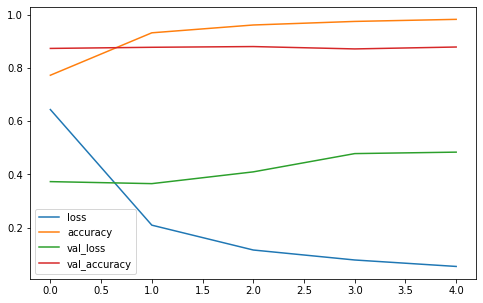

In [44]:
pd.DataFrame(history_model_4.history).plot(figsize=(8, 5))
plt.show()

In [45]:
results["model_4"] = {
    "validation": model_4.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_4.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 4s 5ms/step - loss: 0.0285 - accuracy: 0.9915


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543},
 'model_3': {'validation': 0.189239963889122, 'training': 0.19647279381752014},
 'model_4': {'validation': 0.8785653114318848, 'training': 0.9915449619293213}}

### Model 5: Conv1D

In [46]:
embedding.set_weights(initial_embedding_weigths)

In [47]:
from tensorflow.keras import layers 

inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs)
x = embedding(x) 
x = layers.Conv1D(
    filters=32, 
    kernel_size=5, 
    strides=1, 
    padding="valid", 
    activation="relu"
)(x) 
x = layers.Conv1D(
    filters=32, 
    kernel_size=5, 
    strides=1, 
    padding="valid", 
    activation="relu"
)(x) 
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(len(np.unique(train_labels)), activation="sigmoid")(x) 
model_5 = tf.keras.Model(
    inputs,
    outputs, 
    name="model_5_conv_1d"
)

In [48]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_5 = model_5.fit(train_sentences,
                              train_labels_dummy,
                              epochs=5,
                              batch_size=32,
                              validation_data=(val_sentences, val_labels_dummy)
                              )

Epoch 1/5
732/732 [==============================] - 9s 6ms/step - loss: 0.8383 - accuracy: 0.6941 - val_loss: 0.4220 - val_accuracy: 0.8536
Epoch 2/5
732/732 [==============================] - 4s 6ms/step - loss: 0.2422 - accuracy: 0.9219 - val_loss: 0.3966 - val_accuracy: 0.8736
Epoch 3/5
732/732 [==============================] - 4s 6ms/step - loss: 0.1046 - accuracy: 0.9677 - val_loss: 0.4422 - val_accuracy: 0.8702
Epoch 4/5
732/732 [==============================] - 4s 6ms/step - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.5496 - val_accuracy: 0.8693
Epoch 5/5
732/732 [==============================] - 4s 6ms/step - loss: 0.0230 - accuracy: 0.9932 - val_loss: 0.6303 - val_accuracy: 0.8712


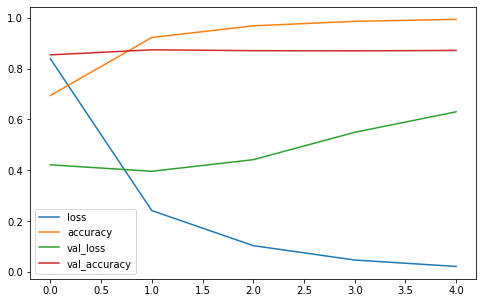

In [49]:
pd.DataFrame(history_model_5.history).plot(figsize=(8, 5))
plt.show()

In [50]:
results["model_5"] = {
    "validation": model_5.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_5.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 3s 3ms/step - loss: 0.0121 - accuracy: 0.9968


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543},
 'model_3': {'validation': 0.189239963889122, 'training': 0.19647279381752014},
 'model_4': {'validation': 0.8785653114318848, 'training': 0.9915449619293213},
 'model_5': {'validation': 0.8712211847305298, 'training': 0.9968400597572327}}

In [51]:
results_step1=pd.DataFrame(results)
results_step1

,model_0,model_1,model_2,model_3,model_4,model_5
validation,0.883689,0.896670,0.875149,0.189240,0.878565,0.871221
training,0.950038,0.977581,0.985866,0.196473,0.991545,0.996840


## Applying Regularization 

In [52]:
from tensorflow.keras import regularizers
embedding_reg = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=32,
                             input_length=max_length,
                             name="embedding_regularized",
                             embeddings_regularizer=regularizers.L2(1e-5)) 

embedding_reg

In [53]:
embedding_reg(text_vectorizer(["hello"])) 

<tf.Tensor: shape=(1, 18, 32), dtype=float32, numpy=
array([[[ 0.01971049,  0.04956447, -0.04498898, -0.04285108,
         -0.02997171, -0.02650551,  0.00992667, -0.01241642,
          0.03625268, -0.00234469,  0.00255215,  0.0297983 ,
          0.04890737, -0.03067819,  0.02791781, -0.00020131,
         -0.00865296,  0.00535163,  0.02148299, -0.00082378,
         -0.03263249, -0.01471297,  0.03745327,  0.00250045,
         -0.01108126, -0.00781824,  0.04474504,  0.04529421,
          0.03629799,  0.01169245,  0.02681491, -0.03757312],
        [-0.04679803, -0.00125933, -0.00809896,  0.00363321,
         -0.0115544 , -0.0220687 , -0.01188046,  0.01239752,
          0.04536885,  0.04956514,  0.03687773, -0.00751104,
          0.02085787,  0.03597367,  0.00982162,  0.02387882,
         -0.03527769,  0.01040135, -0.01290347, -0.01188893,
         -0.0239948 , -0.04676169,  0.01820729, -0.01263307,
          0.03560979,  0.04945308, -0.03964328,  0.04440779,
         -0.01435176, -0.045376

In [54]:
embedding_reg_initial_weights = embedding_reg.get_weights() 

In [55]:

inputs = layers.Input(shape=(1,), dtype="string") # inputs 
x = text_vectorizer(inputs) 
x = embedding_reg(x) # create an embedding of the numerized numbers 
x = layers.Dropout(0.4)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [56]:
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"]) 

model_1_history = model_1.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=10)

Epoch 1/10
732/732 [==============================] - 4s 5ms/step - loss: 1.4886 - accuracy: 0.6100 - val_loss: 1.0870 - val_accuracy: 0.7513
Epoch 2/10
732/732 [==============================] - 3s 4ms/step - loss: 0.8340 - accuracy: 0.8047 - val_loss: 0.6975 - val_accuracy: 0.8275
Epoch 3/10
732/732 [==============================] - 3s 4ms/step - loss: 0.5797 - accuracy: 0.8585 - val_loss: 0.5655 - val_accuracy: 0.8589
Epoch 4/10
732/732 [==============================] - 3s 4ms/step - loss: 0.4682 - accuracy: 0.8904 - val_loss: 0.5038 - val_accuracy: 0.8705
Epoch 5/10
732/732 [==============================] - 3s 5ms/step - loss: 0.4049 - accuracy: 0.9062 - val_loss: 0.4693 - val_accuracy: 0.8799
Epoch 6/10
732/732 [==============================] - 3s 4ms/step - loss: 0.3607 - accuracy: 0.9186 - val_loss: 0.4496 - val_accuracy: 0.8823
Epoch 7/10
732/732 [==============================] - 3s 4ms/step - loss: 0.3319 - accuracy: 0.9292 - val_loss: 0.4352 - val_accuracy: 0.8881
Epoch 

In [57]:
results["model_1_with_droput"] = {
    "validation": model_1.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_1.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 2s 3ms/step - loss: 0.2308 - accuracy: 0.9631


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543},
 'model_3': {'validation': 0.189239963889122, 'training': 0.19647279381752014},
 'model_4': {'validation': 0.8785653114318848, 'training': 0.9915449619293213},
 'model_5': {'validation': 0.8712211847305298, 'training': 0.9968400597572327},
 'model_1_with_droput': {'validation': 0.8877882361412048,
  'training': 0.9631479978561401}}

In [58]:
embedding_reg.set_weights(embedding_reg_initial_weights)
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_reg(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(32, activation="tanh", recurrent_regularizer='l2')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 
model_2_history = model_2.fit(train_sentences, 
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=10)

Epoch 1/10
732/732 [==============================] - 7s 7ms/step - loss: 1.2925 - accuracy: 0.4965 - val_loss: 0.7266 - val_accuracy: 0.7657
Epoch 2/10
732/732 [==============================] - 5s 6ms/step - loss: 0.6056 - accuracy: 0.8187 - val_loss: 0.4755 - val_accuracy: 0.8613
Epoch 3/10
732/732 [==============================] - 5s 6ms/step - loss: 0.3833 - accuracy: 0.9002 - val_loss: 0.4076 - val_accuracy: 0.8803
Epoch 4/10
732/732 [==============================] - 5s 7ms/step - loss: 0.3048 - accuracy: 0.9208 - val_loss: 0.4038 - val_accuracy: 0.8833
Epoch 5/10
732/732 [==============================] - 5s 7ms/step - loss: 0.2535 - accuracy: 0.9346 - val_loss: 0.4085 - val_accuracy: 0.8803
Epoch 6/10
732/732 [==============================] - 5s 6ms/step - loss: 0.2258 - accuracy: 0.9414 - val_loss: 0.4282 - val_accuracy: 0.8822
Epoch 7/10
732/732 [==============================] - 5s 6ms/step - loss: 0.2046 - accuracy: 0.9481 - val_loss: 0.4364 - val_accuracy: 0.8815
Epoch 

In [59]:
results["model_2_with_droput"] = {
    "validation": model_2.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_2.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 3s 4ms/step - loss: 0.0872 - accuracy: 0.9821


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543},
 'model_3': {'validation': 0.189239963889122, 'training': 0.19647279381752014},
 'model_4': {'validation': 0.8785653114318848, 'training': 0.9915449619293213},
 'model_5': {'validation': 0.8712211847305298, 'training': 0.9968400597572327},
 'model_1_with_droput': {'validation': 0.8877882361412048,
  'training': 0.9631479978561401},
 'model_2_with_droput': {'validation': 0.8744662404060364,
  'training': 0.9820650815963745}}

In [60]:
embedding_reg.set_weights(embedding_reg_initial_weights)
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding_reg(x) 
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(16, recurrent_regularizer='l2'))(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(np.unique(train_labels)), activation="sigmoid")(x) 

model_4 = tf.keras.Model(
    inputs, 
    outputs, 
    name="model_4_bidirectional"
)
model_4.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["accuracy"] 
)

history_model_4 = model_4.fit(train_sentences,
                              train_labels_dummy, 
                              validation_data=(val_sentences, val_labels_dummy), 
                              epochs=10) 

Epoch 1/10
732/732 [==============================] - 10s 9ms/step - loss: 1.2090 - accuracy: 0.5721 - val_loss: 0.5551 - val_accuracy: 0.8379
Epoch 2/10
732/732 [==============================] - 6s 8ms/step - loss: 0.4929 - accuracy: 0.8610 - val_loss: 0.4283 - val_accuracy: 0.8668
Epoch 3/10
732/732 [==============================] - 6s 8ms/step - loss: 0.3544 - accuracy: 0.8998 - val_loss: 0.4018 - val_accuracy: 0.8755
Epoch 4/10
732/732 [==============================] - 7s 9ms/step - loss: 0.2825 - accuracy: 0.9212 - val_loss: 0.4132 - val_accuracy: 0.8798
Epoch 5/10
732/732 [==============================] - 6s 8ms/step - loss: 0.2426 - accuracy: 0.9306 - val_loss: 0.4120 - val_accuracy: 0.8845
Epoch 6/10
732/732 [==============================] - 6s 8ms/step - loss: 0.2195 - accuracy: 0.9392 - val_loss: 0.3990 - val_accuracy: 0.8864
Epoch 7/10
732/732 [==============================] - 6s 8ms/step - loss: 0.1982 - accuracy: 0.9465 - val_loss: 0.4215 - val_accuracy: 0.8861
Epoch

In [61]:
train_sentences.shape

(23418,)

In [62]:
results["model_4_with_droput"] = {
    "validation": model_4.evaluate(val_sentences, val_labels_dummy)[1],
    "training": model_4.evaluate(train_sentences, train_labels_dummy)[1]
}

results

732/732 [==============================] - 3s 5ms/step - loss: 0.0866 - accuracy: 0.9807


{'model_0': {'validation': 0.8836891545687446, 'training': 0.9500384319754035},
 'model_1': {'validation': 0.8966695070266724, 'training': 0.9775813221931458},
 'model_2': {'validation': 0.8751494288444519, 'training': 0.985865592956543},
 'model_3': {'validation': 0.189239963889122, 'training': 0.19647279381752014},
 'model_4': {'validation': 0.8785653114318848, 'training': 0.9915449619293213},
 'model_5': {'validation': 0.8712211847305298, 'training': 0.9968400597572327},
 'model_1_with_droput': {'validation': 0.8877882361412048,
  'training': 0.9631479978561401},
 'model_2_with_droput': {'validation': 0.8744662404060364,
  'training': 0.9820650815963745},
 'model_4_with_droput': {'validation': 0.8758326172828674,
  'training': 0.9807413220405579}}

# Embedding Visualization 

In [63]:
# Get the weight matrix of embedding layer 
# these are the numerical representations of each token in our training data 
embed_weights = model_1.get_layer("embedding_regularized").get_weights()[0] 
embed_weights.shape

(10000, 32)

10000 is the length of the Vocabulary. <br>
32 is the lenght of the representation of each token.

In [64]:
vocab = text_vectorizer.get_vocabulary()

In [65]:
import io 

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [66]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

# new Notebook 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>